In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_ptiles_comp
from viz.fit import plot_all_losses

import yaml

In [ ]:
from os.path import exists, join, splitext

In [ ]:
import pickle as pkl
with open('../../misc/predictions/test_mumbai.pickle', 'rb') as handle:
    PD = pkl.load(handle)

In [5]:
PD['m0']['MCMC']['m1']['df_prediction'].keys()

Index(['date', 'S', 'E', 'I', 'R_recov', 'R_fatal', 'C', 'D', 'active',
       'recovered', 'deceased', 'total'],
      dtype='object')

In [6]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [7]:
PD['m0']['MCMC']['ensemble_mean_forecast']['df_prediction']

,date,total,deceased,recovered,active
0,2020-09-29,203126.1400,8882.0000,166535.0000,27709.1400
1,2020-09-30,205662.6410,8927.7090,168678.9820,28055.9500
2,2020-10-01,207890.6100,8973.8800,170834.1945,28082.5355
3,2020-10-02,209923.4735,9020.2435,172980.9360,27922.2940
4,2020-10-03,211827.6545,9066.7975,175108.5245,27652.3325
...,...,...,...,...,...
79,2020-12-17,299260.1030,12209.4260,275495.2265,11555.4505
80,2020-12-18,300008.3960,12241.8460,276328.2465,11438.3035
81,2020-12-19,300749.0485,12274.0010,277152.4765,11322.5710
82,2020-12-20,301482.2040,12305.8645,277968.0730,11208.2665


In [8]:
import matplotlib as mpl
## for Palatino and other serif fonts use:
plt.rcParams.update({
    'font.size': 12,
 })

total


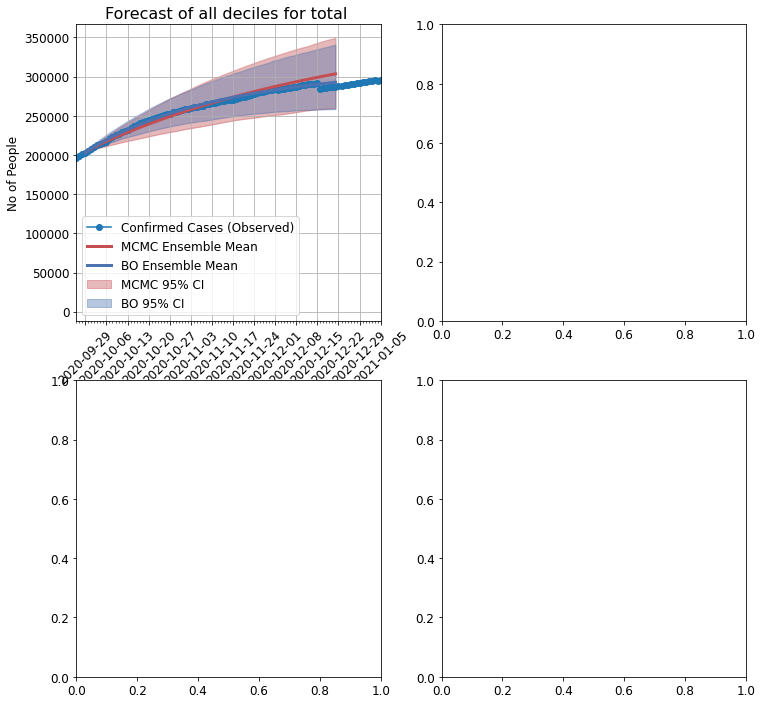

In [9]:
fig,axs = plt.subplots(figsize=(12,12),nrows=2,ncols=2) 
plot_ptiles_comp(PD['m1'], compartment=config['forecast']['plot_ptiles_for_columns'][0],ax=axs.flat[0])
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/CI.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

In [10]:
import pandas as pd
PD['m0']['MCMC']['ensemble_mean_forecast']['df_prediction'].keys()

Index(['date', 'total', 'deceased', 'recovered', 'active'], dtype='object')

In [11]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']

In [12]:
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['df_loss']['train']
        df['agg'] = df.mean()
        df_compiled[model].append(df)
        

In [13]:
np.linspace(0,100,42)

array([  0.        ,   2.43902439,   4.87804878,   7.31707317,
         9.75609756,  12.19512195,  14.63414634,  17.07317073,
        19.51219512,  21.95121951,  24.3902439 ,  26.82926829,
        29.26829268,  31.70731707,  34.14634146,  36.58536585,
        39.02439024,  41.46341463,  43.90243902,  46.34146341,
        48.7804878 ,  51.2195122 ,  53.65853659,  56.09756098,
        58.53658537,  60.97560976,  63.41463415,  65.85365854,
        68.29268293,  70.73170732,  73.17073171,  75.6097561 ,
        78.04878049,  80.48780488,  82.92682927,  85.36585366,
        87.80487805,  90.24390244,  92.68292683,  95.12195122,
        97.56097561, 100.        ])

In [14]:
df_compiled['MCMC'][0]

total        0.296606
active        4.04796
recovered     0.67072
deceased     0.452903
agg           1.36705
Name: train, dtype: object

In [15]:
import pandas as pd
def comp_bar(PD,loss_type,ax):
    which_compartments = ['total', 'active', 'recovered', 'deceased','agg']
    df_compiled = {"MCMC":[],"BO":[]}
    for run,run_dict in PD.items():
        for model,model_dict in run_dict.items():
            if loss_type in ['train','test']:
                df = model_dict['m1']['df_loss'][loss_type]
                df['agg'] = df.mean()
                df_compiled[model].append(df)
            else:
                df = model_dict['ensemble_mean_forecast']['df_loss']
                df['agg'] = np.mean(list(df.values()))
                df2 = {comp:df[comp] for comp in which_compartments}
                df_compiled[model].append(df2)
    stats = {}
    stats['MCMC'] = (pd.DataFrame(df_compiled['MCMC']).describe()).loc[['mean','std']]
    stats['BO'] = (pd.DataFrame(df_compiled['BO']).describe()).loc[['mean','std']]
    barWidth = 0.3
    bars1 = stats['MCMC'].loc[['mean']].values[0]
    bars2 = stats['BO'].loc[['mean']].values[0]
    yer1 = stats['MCMC'].loc[['std']].values[0]
    yer2 = stats['BO'].loc[['std']].values[0]
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    ax.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
    ax.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
    ax.grid(b = True,axis = 'y')
    ax.set_xticks([r + barWidth/2 for r in range(len(bars1))])
    ax.set_xticklabels(which_compartments)
    ax.set_ylabel('MAPE Loss')
    ax.set_title(f'Best {loss_type} Loss')
    ax.legend()

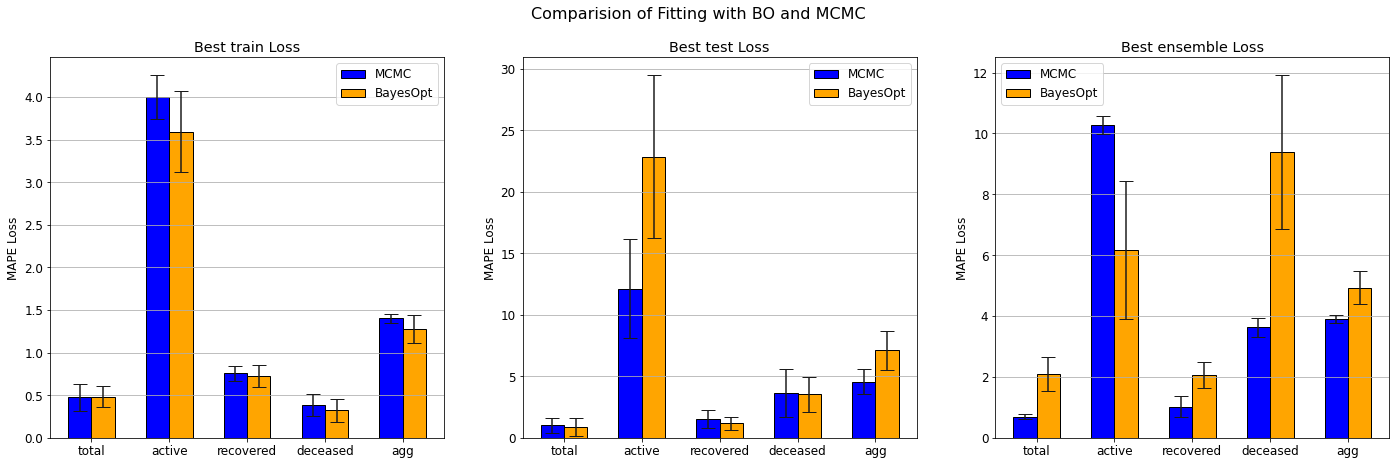

In [17]:
fig,axs = plt.subplots(figsize=(24,7),nrows=1,ncols=3)
comp_bar(PD,'train',axs.flat[0])
comp_bar(PD,'test',axs.flat[1])
comp_bar(PD,'ensemble',axs.flat[2])
fig.suptitle('Comparision of Fitting with BO and MCMC', fontsize=16)
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/Bar_plots.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

In [17]:
stats['BO'].loc[['mean']]

,total,active,recovered,deceased,agg
mean,0.484127,3.592388,0.721676,0.322366,1.280139


## Comparing best loss from MCMC vs BO

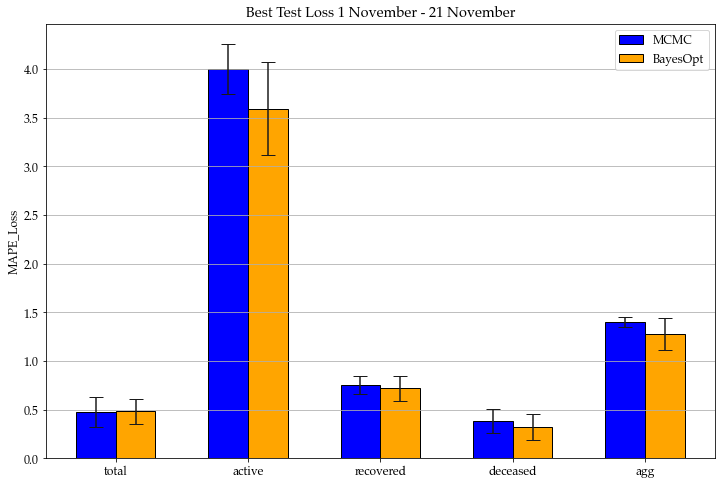

In [23]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.3

plt.figure(figsize=(12,8))
# Choose the height of the blue bars
bars1 = stats['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Best Train Loss 1 November - 21 November')
plt.legend()
 
# Show graphic
plt.show()


## Comparing Ensemble loss from MCMC vs BO

In [ ]:
PD['m0']['MCMC']['ensemble_mean_forecast']['df_loss']

In [ ]:
df_compiled_ens = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['ensemble_mean_forecast']['df_loss']
        df['agg'] = np.mean(list(df.values()))
        df2 = {comp:df[comp] for comp in which_compartments}
        df_compiled_ens[model].append(df2)

In [ ]:
import pandas as pd
stats_ens = {}
stats_ens['MCMC'] = (pd.DataFrame(df_compiled_ens['MCMC']).describe()).loc[['mean','std']]
stats_ens['BO'] = (pd.DataFrame(df_compiled_ens['BO']).describe()).loc[['mean','std']]

In [ ]:
pd.DataFrame(df_compiled_ens['BO'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(12,8))
# Choose the height of the blue bars
bars1 = stats_ens['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats_ens['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats_ens['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats_ens['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Ensemble Loss on Test 1 November - 21 November')
plt.legend()
 
# Show graphic
plt.show()

## DIC 

In [ ]:
df_compiled_DIC = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['metric']['DIC']
        df_compiled_DIC[model].append(df)
df_compiled_DIC

In [ ]:
barWidth = 0.3
plt.figure(figsize=(10,13))
# Choose the height of the blue bars
bars1 = [np.mean(df_compiled_DIC['MCMC'])]
 
# Choose the height of the cyan bars
bars2 = [np.mean(df_compiled_DIC['BO'])]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(df_compiled_DIC['MCMC'])]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(df_compiled_DIC['BO'])]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['MCMC                                    BO'])
plt.ylabel('DIC')
plt.title('DIC Values on Train for 25 Aug to 16 Sep')
plt.legend()
 
# Show graphic
plt.show()

## Percentile Loss

In [ ]:
PD['m0']['MCMC']['uncertainty_forecasts'].keys()

In [ ]:
df_compiled_perc_loss = {"MCMC":[],"BO":[]}
percentiles = []

for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = {}
        percentiles = list(model_dict['uncertainty_forecasts'].keys())
        for perc,perc_dict in model_dict['uncertainty_forecasts'].items():
            df[perc] = perc_dict['df_loss_perc']['test']['total']
        df_compiled_perc_loss[model].append(df)

In [ ]:
pd.DataFrame(df_compiled_perc_loss['MCMC'])

In [ ]:
stats_perc_MCMC = pd.DataFrame(df_compiled_perc_loss['MCMC']).describe().loc[['mean','std']]
stats_perc_BO = pd.DataFrame(df_compiled_perc_loss['BO']).describe().loc[['mean','std']]

In [ ]:
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(12,8))
plt.errorbar(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'orange',label='BO',yerr =list(stats_perc_BO.loc['std'].values) ,elinewidth =3,capthick =3,barsabove = True)
plt.errorbar(list(stats_perc_MCMC.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'blue',label = 'MCMC',yerr = list(stats_perc_MCMC.loc['std'].values),elinewidth =3,capthick =3,barsabove = True)


# general layout
plt.grid(b = True,axis = 'y')
plt.ylabel('Perc Loss on Total Compartment')
plt.xlabel('Percentiles')
plt.title('Day Wise Percentile Loss Values on Test for 8 November - 29 November')
plt.legend()
 
# Show graphic
plt.show()

In [ ]:
from viz.fit import plot_comp_density_plots,plot_histogram

In [ ]:
figs, axs = plt.subplots(4,2,figsize = [12,17])
X= {}
plot_comp_density_plots(PD,figs,axs)
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/hist.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)